In [1]:
# Get the data and take a look at it
import pandas as pd
import sqlite3

# Connect to the local SQLite database
conn = sqlite3.connect('../cms_synthetic_claims/cms_synthetic_claims.db')

# Run the PRAGMA table_info command for each table
tables = pd.read_sql_query("SELECT name FROM sqlite_master WHERE type='table';", conn)
for table in tables['name']:
    info = pd.read_sql_query(f"PRAGMA table_info({table});", conn)
    print(f"Table: {table}")
    print(info)
    print()

df_inpatient_claims = pd.read_sql_query("SELECT * FROM raw_cms_claims", conn)
# df_inpatient_claims = pd.read_sql_query("SELECT * FROM raw_cms_claims GROUP BY CLM_ID;", conn)
conn.close()

Table: raw_cms_claims
     cid                         name       type  notnull dflt_value  pk
0      0                      BENE_ID    INTEGER        0       None   0
1      1                       CLM_ID    INTEGER        0       None   0
2      2   NCH_NEAR_LINE_REC_IDENT_CD       TEXT        0       None   0
3      3              NCH_CLM_TYPE_CD    INTEGER        0       None   0
4      4                  CLM_FROM_DT  TIMESTAMP        0       None   0
..   ...                          ...        ...      ...        ...  ..
192  192     CLM_UNCOMPD_CARE_PMT_AMT       REAL        0       None   0
193  193                 CLM_LINE_NUM    INTEGER        0       None   0
194  194                     REV_CNTR    INTEGER        0       None   0
195  195                     HCPCS_CD       TEXT        0       None   0
196  196  REV_CNTR_DDCTBL_COINSRNC_CD       REAL        0       None   0

[197 rows x 6 columns]

Table: raw_cms_beneficiary_2025
     cid               name       type  notnu

In [2]:
# Thats a lot of data, just take a subset of the columns

# Select a subset of columns to keep
columns_to_keep = [
    'BENE_ID', # unique beneficiary identifier
    'CLM_ID', # unique claim identifier
    'CLM_FROM_DT', # claim start date
    'CLM_THRU_DT', # claim through date
]

# we need claim data, but we want to add that a specific way

# what to do about 1 bene having multiple claims?

df_inpatient_subset = df_inpatient_claims[columns_to_keep].copy()

# Add a new column for the number of days between CLM_FROM_DT and CLM_THRU_DT
df_inpatient_subset['CLM_NUM_DAYS'] = (
    pd.to_datetime(df_inpatient_subset['CLM_THRU_DT']) - pd.to_datetime(df_inpatient_subset['CLM_FROM_DT'])
).dt.days



In [3]:
# df_inpatient_subset.head()
df_inpatient_subset

,BENE_ID,CLM_ID,CLM_FROM_DT,CLM_THRU_DT,CLM_NUM_DAYS
0,-10000010254618,-10000930037831,2015-03-25 00:00:00,2015-03-25 00:00:00,0
1,-10000010254653,-10000930038030,2015-09-24 00:00:00,2015-09-24 00:00:00,0
2,-10000010254653,-10000930038031,2017-05-09 00:00:00,2017-05-10 00:00:00,1
3,-10000010254656,-10000930038162,2017-01-14 00:00:00,2017-01-14 00:00:00,0
4,-10000010254656,-10000930038162,2017-01-14 00:00:00,2017-01-14 00:00:00,0
...,...,...,...,...,...
58061,-10000010288008,-10000931485965,2020-01-08 00:00:00,2020-01-14 00:00:00,6
58062,-10000010288008,-10000931485967,2020-10-23 00:00:00,2020-10-23 00:00:00,0
58063,-10000010288008,-10000931485969,2021-08-22 00:00:00,2021-08-23 00:00:00,1
58064,-10000010288008,-10000931485971,2021-09-13 00:00:00,2021-09-16 00:00:00,3


In [4]:
# add the diagnosis codes
# Add all ICD_DGNS_CD1-25 and CLM_POA_IND_SW1-25 columns from df_inpatient_claims to df_inpatient_subset

# IGNORE POA FOR NOW, MAYBE LATER

# Identify the columns to add
diagnosis_cols = [f'ICD_DGNS_CD{i}' for i in range(1, 26)]
# poa_cols = [f'CLM_POA_IND_SW{i}' for i in range(1, 26)]

# Only keep columns that exist in df_inpatient_claims
diagnosis_cols = [col for col in diagnosis_cols if col in df_inpatient_claims.columns]
# poa_cols = [col for col in poa_cols if col in df_inpatient_claims.columns]

# Add the principal diagnosis code column
df_inpatient_subset['PRNCPAL_DGNS_CD'] = df_inpatient_claims['PRNCPAL_DGNS_CD'].values

# Create a new column that concatenates all diagnosis codes for each claim into a single string
# df_inpatient_subset['ALL_DGNS_CODES'] = df_inpatient_claims[diagnosis_cols].astype(str).agg('|'.join, axis=1)

# Add these columns to the subset DataFrame
df_inpatient_subset = pd.concat(
    # [df_inpatient_subset, df_inpatient_claims[diagnosis_cols + poa_cols].reset_index(drop=True)],
    # axis=1
    [df_inpatient_subset, df_inpatient_claims[diagnosis_cols].reset_index(drop=True)],
    axis=1
)

In [5]:
# df_inpatient_subset.head()
df_inpatient_subset

,BENE_ID,CLM_ID,CLM_FROM_DT,CLM_THRU_DT,CLM_NUM_DAYS,PRNCPAL_DGNS_CD,ICD_DGNS_CD1,ICD_DGNS_CD2,ICD_DGNS_CD3,ICD_DGNS_CD4,...,ICD_DGNS_CD16,ICD_DGNS_CD17,ICD_DGNS_CD18,ICD_DGNS_CD19,ICD_DGNS_CD20,ICD_DGNS_CD21,ICD_DGNS_CD22,ICD_DGNS_CD23,ICD_DGNS_CD24,ICD_DGNS_CD25
0,-10000010254618,-10000930037831,2015-03-25 00:00:00,2015-03-25 00:00:00,0,S134XX,S134XX,R4689,E781,J329,...,None,None,None,None,None,None,None,None,None,None
1,-10000010254653,-10000930038030,2015-09-24 00:00:00,2015-09-24 00:00:00,0,Z3480,T7432X,E669,C50919,None,...,None,None,None,None,None,None,None,None,None,None
2,-10000010254653,-10000930038031,2017-05-09 00:00:00,2017-05-10 00:00:00,1,T7432X,T7432X,E669,C50929,None,...,None,None,None,None,None,None,None,None,None,None
3,-10000010254656,-10000930038162,2017-01-14 00:00:00,2017-01-14 00:00:00,0,S8290X,S8290X,G40909,R569,Z8669,...,None,None,None,None,None,None,None,None,None,None
4,-10000010254656,-10000930038162,2017-01-14 00:00:00,2017-01-14 00:00:00,0,S8290X,S8290X,G40909,R569,Z8669,...,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58061,-10000010288008,-10000931485965,2020-01-08 00:00:00,2020-01-14 00:00:00,6,T50901A,T7432X,T50901A,J329,R931,...,None,None,None,None,None,None,None,None,None,None
58062,-10000010288008,-10000931485967,2020-10-23 00:00:00,2020-10-23 00:00:00,0,T50901A,Z733,F0280,T50901A,J329,...,None,None,None,None,None,None,None,None,None,None
58063,-10000010288008,-10000931485969,2021-08-22 00:00:00,2021-08-23 00:00:00,1,T50901A,Z608,Z733,G309,T50901A,...,None,None,None,None,None,None,None,None,None,None
58064,-10000010288008,-10000931485971,2021-09-13 00:00:00,2021-09-16 00:00:00,3,T50901A,Z608,Z733,F0280,T50901A,...,None,None,None,None,None,None,None,None,None,None


In [6]:
# split the data into training and testing sets
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df_inpatient_subset, test_size=0.2, random_state=42)

In [7]:
train_df
# test_df

,BENE_ID,CLM_ID,CLM_FROM_DT,CLM_THRU_DT,CLM_NUM_DAYS,PRNCPAL_DGNS_CD,ICD_DGNS_CD1,ICD_DGNS_CD2,ICD_DGNS_CD3,ICD_DGNS_CD4,...,ICD_DGNS_CD16,ICD_DGNS_CD17,ICD_DGNS_CD18,ICD_DGNS_CD19,ICD_DGNS_CD20,ICD_DGNS_CD21,ICD_DGNS_CD22,ICD_DGNS_CD23,ICD_DGNS_CD24,ICD_DGNS_CD25
54803,-10000010285265,-10000931382342,2020-02-07 00:00:00,2020-02-07 00:00:00,0,T7431X,T7431X,J209,E785,R931,...,Z653,E669,P292,None,None,None,None,None,None,None
54500,-10000010285023,-10000931374850,2020-07-31 00:00:00,2020-07-31 00:00:00,0,S2239X,S2239X,N181,E1121,G53,...,None,None,None,None,None,None,None,None,None,None
36612,-10000010274658,-10000930936103,2021-03-12 00:00:00,2021-03-12 00:00:00,0,Z733,Z733,T7432X,Z951,Z608,...,K635,O039,E669,P292,D649,R7303,Z591,Z560,R4689,None
29173,-10000010270941,-10000930756789,2023-02-12 00:00:00,2023-02-13 00:00:00,1,T50901A,Z733,Z608,R931,I259,...,E119,E8881,E669,O039,D649,R7303,P292,Z560,None,None
6186,-10000010257787,-10000930166772,2018-10-05 00:00:00,2018-10-05 00:00:00,0,Z608,Z608,Z733,Z604,M7918,...,D649,R7303,Z653,E669,F329,Z591,R4689,K37,Z9049,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54343,-10000010284878,-10000931368856,2016-06-22 00:00:00,2016-06-22 00:00:00,0,Z604,Z604,Z608,Z733,N1830,...,I10,R739,R7303,E8881,E1141,E669,E781,Z591,E119,D649
38158,-10000010275202,-10000930959314,2022-08-01 00:00:00,2022-08-01 00:00:00,0,Z608,Z608,T7432X,Z733,N1830,...,E119,E8881,P292,Z954,I350,R931,I259,E785,E669,G4733
860,-10000010255242,-10000930058047,2015-03-17 00:00:00,2015-03-17 00:00:00,0,Z733,Z733,Z653,N182,E1129,...,None,None,None,None,None,None,None,None,None,None
15795,-10000010262670,-10000930401190,2018-05-14 00:00:00,2018-05-14 00:00:00,0,Z733,Z733,Z604,N182,R801,...,I259,E8881,E781,P292,E119,J329,O039,C50919,R7303,D649


In [8]:
# Use target/mean encoding for the principal diagnosis code
# This will give us a base idea of the mean time associated with each principal diagnosis code

# Compute mean CLM_NUM_DAYS for each principal diagnosis code
principal_code_tmean = train_df.groupby('PRNCPAL_DGNS_CD')['CLM_NUM_DAYS'].mean()

# Map the mean value back to each row based on PRNCPAL_DGNS_CD
train_df['PRNCPAL_DGNS_CD_TMEAN'] = train_df['PRNCPAL_DGNS_CD'].map(principal_code_tmean)

In [9]:
train_df

,BENE_ID,CLM_ID,CLM_FROM_DT,CLM_THRU_DT,CLM_NUM_DAYS,PRNCPAL_DGNS_CD,ICD_DGNS_CD1,ICD_DGNS_CD2,ICD_DGNS_CD3,ICD_DGNS_CD4,...,ICD_DGNS_CD17,ICD_DGNS_CD18,ICD_DGNS_CD19,ICD_DGNS_CD20,ICD_DGNS_CD21,ICD_DGNS_CD22,ICD_DGNS_CD23,ICD_DGNS_CD24,ICD_DGNS_CD25,PRNCPAL_DGNS_CD_TMEAN
54803,-10000010285265,-10000931382342,2020-02-07 00:00:00,2020-02-07 00:00:00,0,T7431X,T7431X,J209,E785,R931,...,E669,P292,None,None,None,None,None,None,None,0.000000
54500,-10000010285023,-10000931374850,2020-07-31 00:00:00,2020-07-31 00:00:00,0,S2239X,S2239X,N181,E1121,G53,...,None,None,None,None,None,None,None,None,None,0.038194
36612,-10000010274658,-10000930936103,2021-03-12 00:00:00,2021-03-12 00:00:00,0,Z733,Z733,T7432X,Z951,Z608,...,O039,E669,P292,D649,R7303,Z591,Z560,R4689,None,0.335183
29173,-10000010270941,-10000930756789,2023-02-12 00:00:00,2023-02-13 00:00:00,1,T50901A,Z733,Z608,R931,I259,...,E8881,E669,O039,D649,R7303,P292,Z560,None,None,3.652709
6186,-10000010257787,-10000930166772,2018-10-05 00:00:00,2018-10-05 00:00:00,0,Z608,Z608,Z733,Z604,M7918,...,R7303,Z653,E669,F329,Z591,R4689,K37,Z9049,None,0.266042
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54343,-10000010284878,-10000931368856,2016-06-22 00:00:00,2016-06-22 00:00:00,0,Z604,Z604,Z608,Z733,N1830,...,R739,R7303,E8881,E1141,E669,E781,Z591,E119,D649,0.044926
38158,-10000010275202,-10000930959314,2022-08-01 00:00:00,2022-08-01 00:00:00,0,Z608,Z608,T7432X,Z733,N1830,...,E8881,P292,Z954,I350,R931,I259,E785,E669,G4733,0.266042
860,-10000010255242,-10000930058047,2015-03-17 00:00:00,2015-03-17 00:00:00,0,Z733,Z733,Z653,N182,E1129,...,None,None,None,None,None,None,None,None,None,0.335183
15795,-10000010262670,-10000930401190,2018-05-14 00:00:00,2018-05-14 00:00:00,0,Z733,Z733,Z604,N182,R801,...,E8881,E781,P292,E119,J329,O039,C50919,R7303,D649,0.335183


In [10]:
# Use target/mean encoding to encode the 'secondary' diagnosis codes based on average length of stay
# For each unique diagnosis code value across all ICD_DGNS_CD1-25 columns,
# compute the mean CLM_NUM_DAYS and add a new column for each ICD_DGNS_CD column with the encoded value

# Get all unique codes across all 25 columns
all_secondary_codes = pd.unique(train_df[diagnosis_cols].values.ravel())

# THIS DOESN"T FACTOR IN THE POA CODES, SHOULD IT? It probably should
# The TMEAN is being used as a feature without enough context based on the reuse of codes across columns, this needs to be fixed
#   - On second thought, maybe this is okay, since the model can learn different weights for each column's TMEAN value
#      - also maybe the codes are in some order anyways?
#    try it both ways and see which is better (need a way to tests first)

# Build a mapping: code -> mean CLM_NUM_DAYS (across any column)
diag_code_Tmeans = {}
for code in all_secondary_codes:
    if pd.isna(code) or code == 'None':
        continue
    mask = (train_df[diagnosis_cols] == code).any(axis=1)
    diag_code_Tmeans[code] = train_df.loc[mask, 'CLM_NUM_DAYS'].mean()

# For each diagnosis column, map the code to the mean value
for col in diagnosis_cols:
    train_df[f'{col}_TMEAN'] = train_df[col].map(diag_code_Tmeans)


In [11]:
# train_df.head()
# train_df.describe()
# train_df
# diag_code_Tmeans
train_df[['BENE_ID', 'CLM_NUM_DAYS', 'PRNCPAL_DGNS_CD', 'PRNCPAL_DGNS_CD_TMEAN', 'ICD_DGNS_CD1', 'ICD_DGNS_CD1_TMEAN']].head()


,BENE_ID,CLM_NUM_DAYS,PRNCPAL_DGNS_CD,PRNCPAL_DGNS_CD_TMEAN,ICD_DGNS_CD1,ICD_DGNS_CD1_TMEAN
54803,-10000010285265,0,T7431X,0.000000,T7431X,1.855367
54500,-10000010285023,0,S2239X,0.038194,S2239X,0.122388
36612,-10000010274658,0,Z733,0.335183,Z733,1.772989
29173,-10000010270941,1,T50901A,3.652709,Z733,1.772989
6186,-10000010257787,0,Z608,0.266042,Z608,1.834857


In [12]:
# Fit a RandomForestRegressor to predict CLM_NUM_DAYS using the TMEAN features
# This will give us a baseline on how long a claim will stay based on the diagnosis codes
# with this prediction we can then identify outliers based on the residuals

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error


# Prepare feature columns (all ICD_DGNS_CD[1:25]_TMEAN)
tmean_cols = [f'ICD_DGNS_CD{i}_TMEAN' for i in range(1, 26)]

# Drop rows with missing values in features or target
# Select only the tmean_cols and CLM_NUM_DAYS, and drop rows with missing values
rf_train_data = train_df[tmean_cols + ['PRNCPAL_DGNS_CD_TMEAN', 'CLM_NUM_DAYS']]

X_train = rf_train_data[tmean_cols + ['PRNCPAL_DGNS_CD_TMEAN']]
y_train = rf_train_data['CLM_NUM_DAYS']

# Fit RandomForestRegressor on all data
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)

# Predict on the same data and evaluate
y_train_pred = rf.predict(X_train)

# Add predictions to the DataFrame
train_df.loc[rf_train_data.index, 'CLM_NUM_DAYS_RF_PRED'] = y_train_pred



In [13]:
# Show a comparison of prediction vs actual
train_df[tmean_cols + ['PRNCPAL_DGNS_CD_TMEAN', 'CLM_NUM_DAYS', 'CLM_NUM_DAYS_RF_PRED']]

,ICD_DGNS_CD1_TMEAN,ICD_DGNS_CD2_TMEAN,ICD_DGNS_CD3_TMEAN,ICD_DGNS_CD4_TMEAN,ICD_DGNS_CD5_TMEAN,ICD_DGNS_CD6_TMEAN,ICD_DGNS_CD7_TMEAN,ICD_DGNS_CD8_TMEAN,ICD_DGNS_CD9_TMEAN,ICD_DGNS_CD10_TMEAN,...,ICD_DGNS_CD19_TMEAN,ICD_DGNS_CD20_TMEAN,ICD_DGNS_CD21_TMEAN,ICD_DGNS_CD22_TMEAN,ICD_DGNS_CD23_TMEAN,ICD_DGNS_CD24_TMEAN,ICD_DGNS_CD25_TMEAN,PRNCPAL_DGNS_CD_TMEAN,CLM_NUM_DAYS,CLM_NUM_DAYS_RF_PRED
54803,1.855367,0.099778,1.015340,1.380763,1.772989,1.366996,3.074904,2.098067,0.937190,0.888931,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0,0.00000
54500,0.122388,0.571157,1.280171,0.456456,0.743167,1.411655,0.725969,1.015340,1.815417,1.921872,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.038194,0,0.00000
36612,1.772989,1.702156,1.920669,1.834857,1.380763,1.366996,2.125285,1.262126,0.555368,1.396541,...,1.725156,1.998092,1.815417,1.975563,1.587340,2.352705,NaN,0.335183,0,0.00000
29173,1.772989,1.834857,1.380763,1.366996,1.000000,1.262126,2.350517,0.311412,1.729914,0.741203,...,1.468877,1.998092,1.815417,1.725156,1.587340,NaN,NaN,3.652709,1,2.37375
6186,1.834857,1.772989,1.700619,1.515848,1.793818,0.701950,1.344176,1.920669,1.380763,1.366996,...,1.921872,1.669449,1.975563,2.352705,1.645140,1.619920,NaN,0.266042,0,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54343,1.700619,1.834857,1.772989,0.555368,1.344176,1.262126,0.566430,1.364848,1.380763,1.366996,...,1.411655,0.333853,1.921872,0.743167,1.975563,0.725969,1.998092,0.044926,0,0.00000
38158,1.834857,1.702156,1.772989,0.555368,1.364848,0.566430,1.344176,1.262126,0.324984,0.472924,...,0.635496,1.291339,1.380763,1.366996,1.015340,1.921872,1.826843,0.266042,0,0.00000
860,1.772989,1.262126,0.566430,1.396541,0.571157,1.280171,1.645140,1.619920,1.411655,1.468877,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.335183,0,0.00000
15795,1.772989,1.700619,0.566430,1.364848,0.339832,1.262126,0.399099,1.280171,0.032847,0.311412,...,1.725156,0.725969,1.729914,1.468877,1.249042,1.815417,1.998092,0.335183,0,0.00000


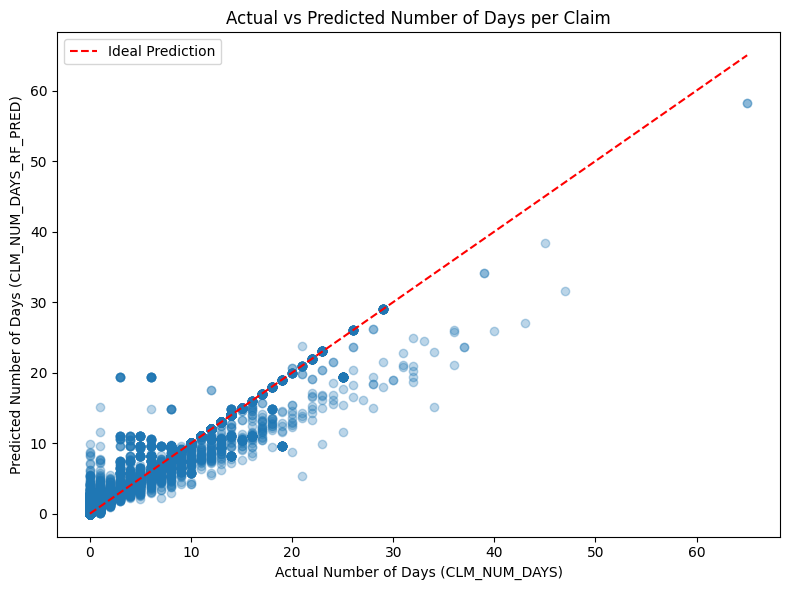

In [14]:
# plot the clm_num_days and the predicted num of days for each claim

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(train_df['CLM_NUM_DAYS'], train_df['CLM_NUM_DAYS_RF_PRED'], alpha=0.3)
plt.xlabel('Actual Number of Days (CLM_NUM_DAYS)')
plt.ylabel('Predicted Number of Days (CLM_NUM_DAYS_RF_PRED)')
plt.title('Actual vs Predicted Number of Days per Claim')
plt.plot([train_df['CLM_NUM_DAYS'].min(), train_df['CLM_NUM_DAYS'].max()],
         [train_df['CLM_NUM_DAYS'].min(), train_df['CLM_NUM_DAYS'].max()],
         color='red', linestyle='--', label='Ideal Prediction')
plt.legend()
plt.tight_layout()
plt.show()

In [15]:
# check feature importances
import pandas as pd

importances = rf.feature_importances_
feature_names = X_train.columns

# Create a DataFrame for easy viewing
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values('importance', ascending=False)

print(importance_df)

# THESE DO SEEM A BIT ODD
# prncipal being really important makes sense
# cd1 being less important fits because it is often a copy of principal
# after that I would expect it mostly to be in number order. Why is it not?

                  feature  importance
25  PRNCPAL_DGNS_CD_TMEAN    0.590463
2      ICD_DGNS_CD3_TMEAN    0.069286
0      ICD_DGNS_CD1_TMEAN    0.031769
8      ICD_DGNS_CD9_TMEAN    0.031443
7      ICD_DGNS_CD8_TMEAN    0.024511
4      ICD_DGNS_CD5_TMEAN    0.024415
3      ICD_DGNS_CD4_TMEAN    0.023786
5      ICD_DGNS_CD6_TMEAN    0.023584
6      ICD_DGNS_CD7_TMEAN    0.022655
1      ICD_DGNS_CD2_TMEAN    0.021451
10    ICD_DGNS_CD11_TMEAN    0.021050
9     ICD_DGNS_CD10_TMEAN    0.018543
13    ICD_DGNS_CD14_TMEAN    0.017765
12    ICD_DGNS_CD13_TMEAN    0.017690
11    ICD_DGNS_CD12_TMEAN    0.015956
15    ICD_DGNS_CD16_TMEAN    0.009579
14    ICD_DGNS_CD15_TMEAN    0.009449
19    ICD_DGNS_CD20_TMEAN    0.006991
16    ICD_DGNS_CD17_TMEAN    0.006892
17    ICD_DGNS_CD18_TMEAN    0.004236
18    ICD_DGNS_CD19_TMEAN    0.002964
20    ICD_DGNS_CD21_TMEAN    0.002255
22    ICD_DGNS_CD23_TMEAN    0.001250
21    ICD_DGNS_CD22_TMEAN    0.001070
23    ICD_DGNS_CD24_TMEAN    0.000547
24    ICD_DG

In [16]:
# Now use IsolationForest on the residuals (difference between actual and predicted days)
# if the results is near -1 then it is an outlier

from sklearn.ensemble import IsolationForest
import numpy as np

# Prepare the feature: difference between actual and predicted days
train_diff_days_inpatient = train_df['CLM_NUM_DAYS'] - train_df['CLM_NUM_DAYS_RF_PRED']

# Reshape for IsolationForest
train_diff_reshape = train_diff_days_inpatient.values.reshape(-1, 1)

# Fit IsolationForest on the difference
iso_diff = IsolationForest(random_state=42, contamination='auto')
iso_diff.fit(train_diff_reshape)

# Get the decision function scores
train_decision_scores = iso_diff.decision_function(train_diff_reshape)

# Store the scores in the dataframe
train_df['CLM_NUM_DAYS_IFOREST_DIFF_SCORE'] = train_decision_scores

In [17]:
train_df[['BENE_ID', 'CLM_ID', 'CLM_NUM_DAYS', 'CLM_NUM_DAYS_RF_PRED', 'CLM_NUM_DAYS_IFOREST_DIFF_SCORE', 'PRNCPAL_DGNS_CD']].sort_values('CLM_NUM_DAYS_IFOREST_DIFF_SCORE', ascending=True)

,BENE_ID,CLM_ID,CLM_NUM_DAYS,CLM_NUM_DAYS_RF_PRED,CLM_NUM_DAYS_IFOREST_DIFF_SCORE,PRNCPAL_DGNS_CD
47940,-10000010281493,-10000931222709,23,9.826167,-0.338124,T50901A
23877,-10000010267224,-10000930594832,37,23.570000,-0.338124,P258
55333,-10000010285753,-10000931395599,25,11.543857,-0.338124,T50901A
52377,-10000010283477,-10000931310723,36,21.035000,-0.338124,T50901A
44070,-10000010278266,-10000931110987,34,15.146000,-0.338124,T50901A
...,...,...,...,...,...,...
860,-10000010255242,-10000930058047,0,0.000000,0.199473,Z733
15795,-10000010262670,-10000930401190,0,0.000000,0.199473,Z733
56422,-10000010286627,-10000931425266,1,1.000000,0.199473,G479
54803,-10000010285265,-10000931382342,0,0.000000,0.199473,T7431X


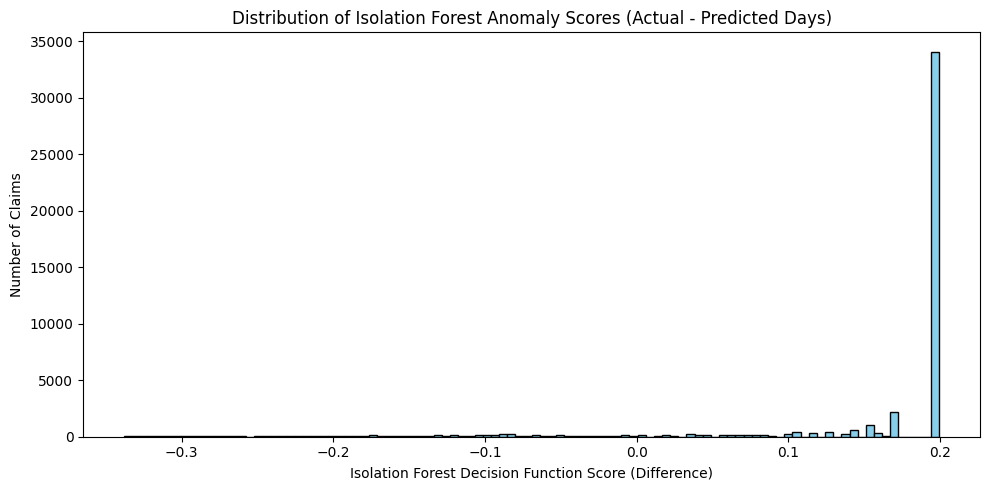

In [18]:
import matplotlib.pyplot as plt

# Visualize the Isolation Forest anomaly scores for the difference between actual and predicted days
plt.figure(figsize=(10, 5))
plt.hist(train_df['CLM_NUM_DAYS_IFOREST_DIFF_SCORE'], bins=100, color='skyblue', edgecolor='k')
plt.xlabel('Isolation Forest Decision Function Score (Difference)')
plt.ylabel('Number of Claims')
plt.title('Distribution of Isolation Forest Anomaly Scores (Actual - Predicted Days)')
plt.tight_layout()
plt.show()

# LETS WORK WITH THE TEST DATA
-------------------
--------------------

In [19]:
# add the principal diagnosis code TMEAN to the test set
test_df['PRNCPAL_DGNS_CD_TMEAN'] = test_df['PRNCPAL_DGNS_CD'].map(principal_code_tmean)

# Map the diagnosis columns to their TMEAN values
for col in diagnosis_cols:
    test_df[f'{col}_TMEAN'] = test_df[col].map(diag_code_Tmeans)

In [20]:
# use the random forest model to predict on the test set


rf_test_data = test_df[tmean_cols + ['PRNCPAL_DGNS_CD_TMEAN', 'CLM_NUM_DAYS']]

X_test = rf_test_data[tmean_cols + ['PRNCPAL_DGNS_CD_TMEAN']]
y_test = rf_test_data['CLM_NUM_DAYS']

# Predict on the same data and evaluate
y_test_pred = rf.predict(X_test)

# Add predictions to the DataFrame
test_df.loc[rf_test_data.index, 'CLM_NUM_DAYS_RF_PRED'] = y_test_pred

In [21]:
test_df

,BENE_ID,CLM_ID,CLM_FROM_DT,CLM_THRU_DT,CLM_NUM_DAYS,PRNCPAL_DGNS_CD,ICD_DGNS_CD1,ICD_DGNS_CD2,ICD_DGNS_CD3,ICD_DGNS_CD4,...,ICD_DGNS_CD17_TMEAN,ICD_DGNS_CD18_TMEAN,ICD_DGNS_CD19_TMEAN,ICD_DGNS_CD20_TMEAN,ICD_DGNS_CD21_TMEAN,ICD_DGNS_CD22_TMEAN,ICD_DGNS_CD23_TMEAN,ICD_DGNS_CD24_TMEAN,ICD_DGNS_CD25_TMEAN,CLM_NUM_DAYS_RF_PRED
12981,-10000010260856,-10000930312741,2022-12-30 00:00:00,2022-12-30 00:00:00,0,T50901A,Z608,Z733,Z951,R931,...,2.399114,1.677934,0.725969,1.815417,1.998092,2.801590,2.352705,1.729914,NaN,5.530
36647,-10000010274743,-10000930940208,2021-03-10 00:00:00,2021-03-10 00:00:00,0,S060X0,S060X0,S069,Z608,Z733,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000
24652,-10000010267636,-10000930612427,2021-09-23 00:00:00,2021-09-23 00:00:00,0,S63509,S63509,T7431X,N1830,E1121,...,0.454545,0.250000,1.975563,1.717808,0.743167,0.725969,1.998092,0.416667,0.333333,0.270
35130,-10000010273834,-10000930895135,2016-09-26 00:00:00,2016-09-27 00:00:00,1,N182,N182,M7918,M542,Z604,...,1.815417,1.262126,1.280171,1.677934,1.921872,2.801590,NaN,NaN,NaN,0.990
25267,-10000010267897,-10000930625863,2015-08-13 00:00:00,2015-08-13 00:00:00,0,S72009,S72009,T7432X,Z608,Z608,...,2.350517,1.015340,2.399114,1.988624,2.444159,1.998092,1.411655,1.815417,1.725156,0.020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39942,-10000010276250,-10000931011798,2020-08-07 00:00:00,2020-08-20 00:00:00,13,J439,Z733,T7432X,J439,E669,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.275
54901,-10000010285480,-10000931387823,2021-12-25 00:00:00,2021-12-26 00:00:00,1,C50919,T7432X,Z733,C50929,E0922,...,1.262126,1.546030,1.015340,2.098067,1.411655,1.677934,1.815417,1.921872,1.717808,1.090
51484,-10000010282782,-10000931281831,2022-10-11 00:00:00,2022-10-11 00:00:00,0,Z608,Z608,Z733,R0902,N1830,...,1.725156,1.262126,1.921872,1.998092,1.815417,1.587340,NaN,NaN,NaN,0.000
26538,-10000010268942,-10000930672207,2019-08-06 00:00:00,2019-08-06 00:00:00,0,Z733,Z733,N181,Z940,R809,...,1.921872,1.998092,1.815417,1.669449,NaN,NaN,NaN,NaN,NaN,0.020


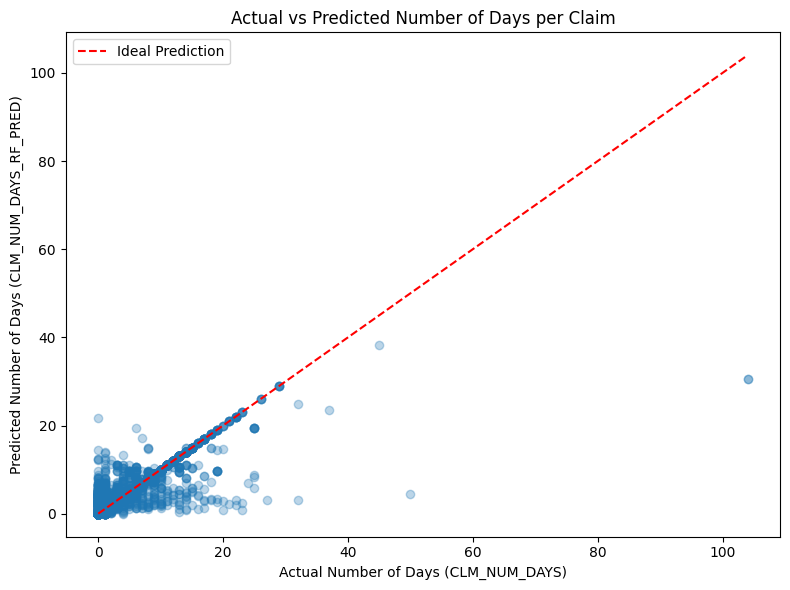

In [22]:
# plot the clm_num_days and the predicted num of days for each claim

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(test_df['CLM_NUM_DAYS'], test_df['CLM_NUM_DAYS_RF_PRED'], alpha=0.3)
plt.xlabel('Actual Number of Days (CLM_NUM_DAYS)')
plt.ylabel('Predicted Number of Days (CLM_NUM_DAYS_RF_PRED)')
plt.title('Actual vs Predicted Number of Days per Claim')
plt.plot([test_df['CLM_NUM_DAYS'].min(), test_df['CLM_NUM_DAYS'].max()],
         [test_df['CLM_NUM_DAYS'].min(), test_df['CLM_NUM_DAYS'].max()],
         color='red', linestyle='--', label='Ideal Prediction')
plt.legend()
plt.tight_layout()
plt.show()

In [23]:
# Now use IsolationForest on the residuals (difference between actual and predicted days)
# if the results is near -1 then it is an outlier

# Prepare the feature: difference between actual and predicted days
test_diff_days_inpatient = test_df['CLM_NUM_DAYS'] - test_df['CLM_NUM_DAYS_RF_PRED']

# Reshape for IsolationForest
test_diff_reshape = test_diff_days_inpatient.values.reshape(-1, 1)

# Get the decision function scores
test_decision_scores = iso_diff.decision_function(test_diff_reshape)

# Store the scores in the dataframe
test_df['CLM_NUM_DAYS_IFOREST_DIFF_SCORE'] = test_decision_scores

In [24]:
test_df[['BENE_ID', 'CLM_ID', 'CLM_NUM_DAYS', 'CLM_NUM_DAYS_RF_PRED', 'CLM_NUM_DAYS_IFOREST_DIFF_SCORE', 'PRNCPAL_DGNS_CD']].sort_values('CLM_NUM_DAYS_IFOREST_DIFF_SCORE', ascending=True)

,BENE_ID,CLM_ID,CLM_NUM_DAYS,CLM_NUM_DAYS_RF_PRED,CLM_NUM_DAYS_IFOREST_DIFF_SCORE,PRNCPAL_DGNS_CD
13400,-10000010261149,-10000930324590,32,3.200000,-0.338124,T50901A
54110,-10000010284768,-10000931363393,19,3.346667,-0.338124,T50901A
4844,-10000010256989,-10000930134838,25,5.837000,-0.338124,T50901A
55435,-10000010285889,-10000931401781,104,30.560000,-0.338124,Z899
50388,-10000010282591,-10000931271137,17,2.787917,-0.338124,T50901A
...,...,...,...,...,...,...
16248,-10000010262670,-10000930401486,0,0.000000,0.199473,Z608
51484,-10000010282782,-10000931281831,0,0.000000,0.199473,Z608
10407,-10000010259637,-10000930261885,0,0.000000,0.199473,Z733
35827,-10000010274268,-10000930912140,14,14.000000,0.199473,Z7682


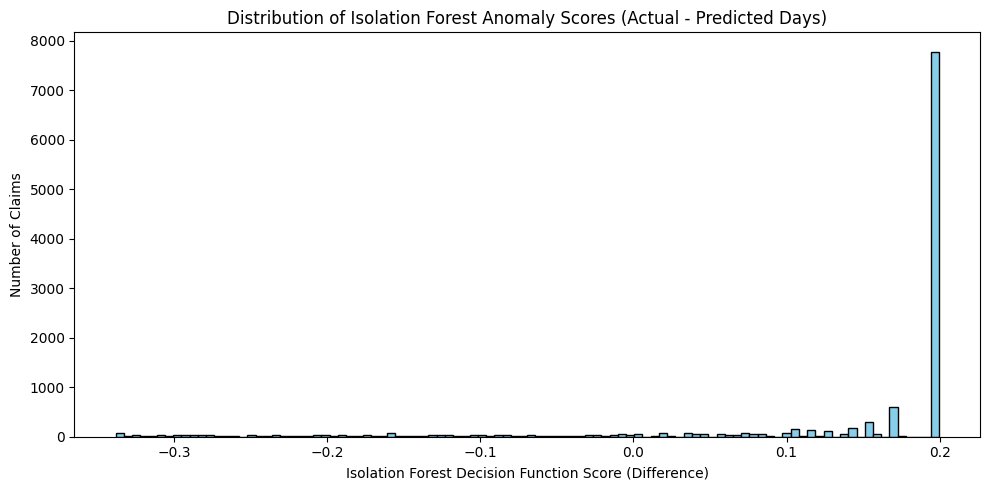

In [25]:
import matplotlib.pyplot as plt

# Visualize the Isolation Forest anomaly scores for the difference between actual and predicted days
plt.figure(figsize=(10, 5))
plt.hist(test_df['CLM_NUM_DAYS_IFOREST_DIFF_SCORE'], bins=100, color='skyblue', edgecolor='k')
plt.xlabel('Isolation Forest Decision Function Score (Difference)')
plt.ylabel('Number of Claims')
plt.title('Distribution of Isolation Forest Anomaly Scores (Actual - Predicted Days)')
plt.tight_layout()
plt.show()

In [26]:
# Test the prediction accuracy of the random forest
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

mse = mean_squared_error(y_test, y_test_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_test_pred)
r2 = r2_score(y_test, y_test_pred)

print(f"Mean Squared Error: {mse:.3f}")
print(f"Root Mean Squared Error: {rmse:.3f}")
print(f"Mean Absolute Error: {mae:.3f}")
print(f"R^2 Score: {r2:.3f}")

Mean Squared Error: 3.288
Root Mean Squared Error: 1.813
Mean Absolute Error: 0.368
R^2 Score: 0.807


In [27]:
import joblib
from pathlib import Path

# Get the full path of the parent directory
root = Path.cwd().parent
base_path = root / "server/models/"

base_path.mkdir(parents=True, exist_ok=True)

joblib.dump(rf, base_path / "rf-length-of-stay.pkl")
joblib.dump(iso_diff, base_path / "iso_diff-length-of-stay.pkl")

['c:\\Workspace\\hack2\\Hackathon25\\server\\models\\iso_diff-length-of-stay.pkl']